# Imports

In [1]:
from dataclasses import dataclass
from pathlib import Path
import pandas as pd
from datetime import datetime
import os
from joblib import Memory
import numpy as np
import seaborn as sns
from typing import Optional, Tuple, Union, Sequence, Dict, Callable, Any
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV, StratifiedKFold, StratifiedShuffleSplit, ParameterGrid
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV, FrozenEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from itertools import combinations
from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib 
import math
import pickle
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    accuracy_score, precision_score,
    recall_score, f1_score, cohen_kappa_score, confusion_matrix
)


# User Settings

In [51]:
@dataclass
class Config:
    data_dir: Path = Path("../../data")
    cache_dir: Path = Path("cache")
    figures_dir: Path = Path("figures")
    results_dir: Path = Path("results")

    real_file: str = "20250301_data_20250510_122405_final_100_train.csv"
    synth_file: str = "20250301_data_20250510_122405_final_100_synth.csv"
    holdout_file: str = "20250301_data_20250510_122405_final_100_holdout.csv"

    random_seed: int = 42
    sampling_size: int = None # None if no sampling
    num_cv: int = 5

    use_existing_thresholds: bool = True
    cache_file: str = "global_thresholds_20250514_074229.pkl"
    use_cached_data: bool = True
    negative_control: str = "negative-control_all.pkl"
    positive_control: str = "positive-control_all.pkl"
    baseline: str = "baseline_all.pkl"
    tstr: str = "tstr_all.pkl"
    augmented: str = "augmented_all.pkl"
    save_data_as_cache: bool = True
    save_data: bool = True

# Set my design
sns.set_theme(
    style="white",
    context="paper",
    palette="colorblind",
    rc={
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "font.size": 7,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 7
    }
)


# Utility Functions

In [3]:
target_col = 'icu_admission_24h'
num_cols = ['age', 'temperature', 'heart_rate', 'respiratory_rate', 'oxygen_saturation', 'systolic_bp', 'diastolic_bp']
cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block', 'night_arrival', 'weekend_arrival']
ord_cols = ['consciousness_level','news_score']
bool_cols = ['night_arrival', 'weekend_arrival']

In [4]:
# DTYPE_MAP: Dict[str, str] = {
#     "icu_admission_24h": "category",
#     "gender": "category",
#     "ethnicity": "category",
#     "chief_complaint": "category",
#     "icd_block": "category",
#     "night_arrival": "category",  # wird später in bool umgewandelt
#     "weekend_arrival": "category",  # wird später in bool umgewandelt
#     "consciousness_level": "category",  # wird geordnet
#     "news_score": "int8", # wird später ordered-Categorical
#     "age": "int16",
#     "temperature": "float32",
#     "heart_rate": "int16",    
#     "respiratory_rate": "int16",
#     "oxygen_saturation": "int16",
#     "systolic_bp": "int16",
#     "diastolic_bp": "int16",
# }

# _INT_SENTINEL = -1  # Platzhalter für fehlende Integer


# # ──────────────────────────────────────────────────────────────────
# # 2) Ordered Categoricals anwenden
# # ──────────────────────────────────────────────────────────────────
# def _set_ordered_categoricals(df: pd.DataFrame) -> pd.DataFrame:
#     """legt die Reihenfolge für bewusstseins- und NEWS-Score fest"""
#     df = df.copy()

#     df["consciousness_level"] = pd.Categorical(
#         df["consciousness_level"],
#         categories=["A", "C", "V", "P", "U"],
#         ordered=True,
#     )

#     df["news_score"] = pd.Categorical(
#         df["news_score"].replace(_INT_SENTINEL, pd.NA),
#         categories=list(range(19)),
#         ordered=True,
#     )

#     return df


# # ──────────────────────────────────────────────────────────────────
# # 3) API-kompatibler Wrapper (falls Legacy-Code `convert_dtypes` nutzt)
# # ──────────────────────────────────────────────────────────────────
# def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:  # noqa: N802
#     """nur noch Ordered-Categoricals - Dtypes stammen schon aus read_csv"""
#     return _set_ordered_categoricals(df)


# # ──────────────────────────────────────────────────────────────────
# # 4) Daten-Loader
# # ──────────────────────────────────────────────────────────────────
# def load_data(
#     real_filename: Union[str, Path],
#     synth_filename: Optional[Union[str, Path]] = None,
#     holdout_filename: Optional[Union[str, Path]] = None,
#     data_dir: Path | None = None,
#     *,
#     dtype_map: Dict[str, str] = DTYPE_MAP,
#     int_sentinel: int = _INT_SENTINEL,
# ) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
#     """
#     Liest bis zu drei CSV-Dateien mit optimierten Dtypes ein und liefert
#     sie als Tuple zurück. Jedes DataFrame wird anschließend um
#     *ordered* Categoricals ergänzt.
#     """
#     data_dir = Path(data_dir or ".").expanduser()

#     def _read(fn: Union[str, Path] | None) -> Optional[pd.DataFrame]:
#         if fn is None:
#             return None

#         df = pd.read_csv(
#             data_dir / fn,
#             dtype=dtype_map,
#             na_values=["", "NA"],
#             low_memory=False,
#         )

#         # fehlende Integer per Sentinel auffüllen, damit cast funktioniert
#         int_cols = [c for c, d in dtype_map.items() if d.startswith("int")]
#         if int_cols:
#             df[int_cols] = df[int_cols].fillna(int_sentinel)

#         return _set_ordered_categoricals(df)

#     return (
#         _read(real_filename),
#         _read(synth_filename),
#         _read(holdout_filename),
#     )

In [5]:
def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Konvertiert bestimmte Spalten des DataFrames in die gewünschten Datentypen:
     - definierte Spalten als category
     - definierte Spalten als pandas Nullable Integer (Int64)
     - consciousness_level und news_score als geordnete Categoricals
    """
    df = df.copy()  # Änderungen nicht am Original vornehmen

    # 1) Kategorische Spalten
    cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block']
    for col in cat_cols:
        # df[col] = df[col].astype('category')
        df[col] = df[col].astype('object') # 'category' führt zu Problemen mit dem OneHotEncoder

    # 2) Integer-Spalten mit Nullable Integer dtype
    int_cols = ['age', 'systolic_bp', 'diastolic_bp',
                'heart_rate', 'respiratory_rate', 'oxygen_saturation']
    for col in int_cols:
        df[col] = df[col].astype('Int64')
        # df[col] = df[col].astype('int32')

    # 3) Geordnete Categoricals
    df['consciousness_level'] = pd.Categorical(
        df['consciousness_level'],
        categories=['A', 'C', 'V', 'P', 'U'],
        ordered=True
    )
    df['news_score'] = pd.Categorical(
        df['news_score'],
        categories=list(range(19)),
        ordered=True
    )

    return df

def load_data(
    real_filename: Union[str, Path],
    synth_filename: Optional[Union[str, Path]] = None,
    holdout_filename: Optional[Union[str, Path]] = None,
    data_dir: Path = None,
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Lädt die realen, synthetischen und optionalen Holdout-CSV-Dateien
    aus data_dir und wandelt sie über convert_dtypes um.

    Returns:
        df_real: pd.DataFrame
        df_synth: Optional[pd.DataFrame]
        df_holdout: Optional[pd.DataFrame]
    """
    def _read_and_convert(fn: Union[str, Path]) -> pd.DataFrame:
        return (
            pd.read_csv(data_dir / fn, low_memory=False)
              .pipe(convert_dtypes)
        )

    df_real    = _read_and_convert(real_filename)
    df_synth   = _read_and_convert(synth_filename)   if synth_filename   else None
    df_holdout = _read_and_convert(holdout_filename) if holdout_filename else None

    return df_real, df_synth, df_holdout

In [6]:
def round_up_auto(n):
    """Aufrundet auf das nächsthöhere Zehner-, Hunderter-, Tausender-…-Vielfache."""
    if n == 0:
        return 0
    base = 10 ** (len(str(abs(int(n)))) - 1)
    return math.ceil(n / base) * base

# Datengrundlage
## Import

In [52]:
cfg = Config()
current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

df_train_real, df_train_synth, df_holdout = load_data(
    cfg.real_file,
    cfg.synth_file,
    cfg.holdout_file,
    data_dir=cfg.data_dir
)

## Col Description, Target, Categories

In [8]:
target_col = 'icu_admission_24h'
num_cols = ['age', 'temperature', 'heart_rate', 'respiratory_rate', 'oxygen_saturation', 'systolic_bp', 'diastolic_bp']
cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block', 'night_arrival', 'weekend_arrival']
ord_cols = ['consciousness_level','news_score']
bool_cols = ['night_arrival', 'weekend_arrival']

In [9]:
train = pd.concat([df_train_real, df_train_synth], axis=0)
min_resources_for_halving = round_up_auto(cfg.num_cv / train[target_col].mean())
cat_categories = {col: train[col].dropna().unique().tolist() for col in cat_cols}
ord_categories = {col: train[col].cat.categories.tolist() for col in ord_cols}

## Holdout-Split into Validation and Test

In [10]:
df_val, df_test = train_test_split(df_holdout, test_size=0.5, random_state=cfg.random_seed) # stratify führt zu Fehler: ausschließlich True

## Addition of df_real_permutated (Negativ Ctrl)

In [11]:
df_train_neg_ctrl = df_train_real.copy()
df_train_neg_ctrl['icu_admission_24h'] = np.random.permutation(df_train_real['icu_admission_24h'].values)

## (Optional) Sampling

In [12]:
if cfg.sampling_size is not None: # stratify bzw. weights führt zu Fehler: ausschließlich True
    df_train_real = df_train_real.sample(n=cfg.sampling_size, replace=True, random_state=cfg.random_seed).reset_index(drop=True)
    df_train_synth = df_train_synth.sample(n=cfg.sampling_size, replace=True, random_state=cfg.random_seed).reset_index(drop=True)
    df_val = df_val.sample(n=cfg.sampling_size, replace=True, random_state=cfg.random_seed).reset_index(drop=True)
    df_test = df_test.sample(n=cfg.sampling_size, replace=True, random_state=cfg.random_seed).reset_index(drop=True)
    df_train_neg_ctrl = df_train_neg_ctrl.sample(n=cfg.sampling_size, replace=True, random_state=cfg.random_seed).reset_index(drop=True)

## Data Splits

1) Originales Training (Real)
X_train_real,      y_train_real

2) Synthetische Daten
X_train_synth,     y_train_synth

3) Augmentiertes Training (Real + Synth)
X_train_augmented, y_train_augmented

4) Negative Kontrolle (permutierte Labels)
X_train_neg_ctrl,  y_train_neg_ctrl

5) Positive Kontrolle (Real vs. Real)
X_train_pos_ctrl,  y_train_pos_ctrl

6) Validation (50 % Hold-out)
X_val,             y_val

7) Test     (50 % Hold-out)
X_test,            y_test

In [13]:
# → echtes Training
X_train_real = df_train_real.drop(columns=[target_col])
y_train_real = df_train_real[target_col].astype(int)

# → Negative Kontrolle (permute Labels)
X_train_neg_ctrl = df_train_neg_ctrl.drop(columns=[target_col])
y_train_neg_ctrl = df_train_neg_ctrl[target_col].astype(int)

# → synthetische Daten
X_train_synth = df_train_synth.drop(columns=[target_col])
y_train_synth = df_train_synth[target_col].astype(int)

# → Augmented (real + synth)
X_train_augmented = pd.concat([X_train_real, X_train_synth], ignore_index=True)
y_train_augmented = pd.concat([y_train_real, y_train_synth], ignore_index=True)

# → Validation (Hold-out 50 %)
X_val = df_val.drop(columns=[target_col])
y_val = df_val[target_col].astype(int)

# → Test (Hold-out 50 %)
X_test = df_test.drop(columns=[target_col])
y_test = df_test[target_col].astype(int)

# ML-Logik
## Preprocessor

In [14]:
memory = Memory(location=cfg.cache_dir, verbose=0)

In [15]:
def build_preprocessor(cat_cols, ord_cols, num_cols, cat_categories, ord_categories):
    """ColumnTransformer mit Imputation, Encoding und PCA."""
    cat_pipe = Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(
            categories=[cat_categories[c] for c in cat_cols],
            handle_unknown='ignore',
            # sparse_output=False
            sparse_output=True
        ))
    ],
    memory=memory)
    ord_pipe = Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(
            categories=[ord_categories[c] for c in ord_cols],
            handle_unknown='use_encoded_value',
            unknown_value=-1
        ))
    ],
    memory=memory)
    num_pipe = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler(with_mean=False)),
        # ('pca', PCA(n_components=0.95, svd_solver='randomized'))
    ],
    memory=memory)
    return ColumnTransformer([
        ('cat', cat_pipe, cat_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', num_pipe, num_cols)
    ])

## Models

In [16]:
def get_models(cat_cols, ord_cols, num_cols, cat_categories, ord_categories, cache_dir):
    """
    Liefert Dictionary: Modellname -> (Pipeline, ParamGrid), plus gemeinsamen CV-Splitter.
    Pipelines nutzen memory=cache_dir, um Vorverarbeitung zu cachen.
    """
    preprocessor = build_preprocessor(cat_cols, ord_cols, num_cols, cat_categories, ord_categories)
    cv = StratifiedKFold(n_splits=cfg.num_cv, shuffle=True, random_state=cfg.random_seed)
    models = {}

    # Logistic Regression
    lr_pipe = Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(
            max_iter=5_000,
            class_weight='balanced',
            random_state=cfg.random_seed,
            n_jobs=1 # Nur bei GridSearchCV ist n_jobs = -1, hier nicht, um "nested parallelism" zu vermeiden
        ))
    ], memory=cache_dir)
    lr_params = {'clf__C': [0.1, 1, 10]}
    models['LogisticRegression'] = (lr_pipe, lr_params)

    # Random Forest
    rf_pipe = Pipeline([
        ('prep', preprocessor),
        ('clf', RandomForestClassifier(
            class_weight='balanced',
            random_state=cfg.random_seed,
            n_jobs=1 # Nur bei GridSearchCV ist n_jobs = -1, hier nicht, um "nested parallelism" zu vermeiden
        ))
    ], memory=cache_dir)
    rf_params = {
        'clf__n_estimators': [200, 400],
        'clf__max_depth': [None, 10],
        'clf__min_samples_leaf': [1, 5]
    }
    models['RandomForest'] = (rf_pipe, rf_params)

    # KNN (Kalibrierung nach Hyperparam-Tuning)
    knn_pipe = Pipeline([
        ('prep', preprocessor),
        ('clf', KNeighborsClassifier(n_jobs=1)) # Nur bei GridSearchCV ist n_jobs = -1, hier nicht, um "nested parallelism" zu vermeiden
    ], memory=cache_dir)
    knn_params = {
        'clf__n_neighbors': [5, 15, 25],
        'clf__weights': ['uniform', 'distance']
    }
    models['KNN'] = (knn_pipe, knn_params)

    return models, cv

## Experiment Logik

In [17]:
def run_experiment(
    X_train, y_train,
    X_test, y_test,
    cat_cols, ord_cols, num_cols,
    cat_categories, ord_categories,
    fixed_thresholds=None,
    cache_dir: Path = cfg.cache_dir,
):
    """
    Hyperparameter-Tuning (HalvingGridSearchCV) + Evaluation.
    KNN wird im Anschluss kalibriert.
    Gibt DataFrame mit Metriken und Dict mit Vorhersagen zurück.
    """
    models, cv = get_models(cat_cols, ord_cols, num_cols, cat_categories, ord_categories, cache_dir)
    results = []
    preds = {}

    for name, (pipe, param_grid) in tqdm(models.items(),desc="Modelle"):
        # logger.info(f"Starte Tuning für {name}")
        # print(f"Starte Tuning für {name}")
        # search = GridSearchCV(pipe, param_grid, cv=5,
        #                   scoring='roc_auc', n_jobs=-1) # Nur hier n_jobs = -1, nicht bei den Modellen, um "nested parallelism" zu vermeiden
  
        # search = HalvingGridSearchCV(
        #     pipe, param_grid, cv=cv, min_resources=min_resources_for_halving,
        #     scoring='roc_auc', n_jobs=-1, factor=2 # Nur hier n_jobs = -1, nicht bei den Modellen, um "nested parallelism" zu vermeiden
        # )

        search = HalvingGridSearchCV(
            pipe, param_grid, 
            cv=StratifiedShuffleSplit(n_splits=3, test_size=0.2,
                                    random_state=cfg.random_seed),
            # min_resources=min_resources_for_halving,
            scoring='roc_auc', n_jobs=-1, factor=2 # Nur hier n_jobs = -1, nicht bei den Modellen, um "nested parallelism" zu vermeiden
        )
        

        
        # Fortschrittsbalken für die inneren Parallel-Jobs
        n_params = len(list(ParameterGrid(param_grid)))        # Kandidatenzahl laut Grid
        n_splits = cv.get_n_splits()                           # z. B. 3
        total_jobs = n_params * n_splits                       # erste Iteration ≈ Obergrenze

        with tqdm_joblib(tqdm(total=total_jobs, desc=f"{name} CV", leave=True, position=1)):
            search.fit(X_train, y_train)
        
        # with tqdm_joblib(tqdm(desc=f"{name} CV", leave=True, position=1)):
        #     search.fit(X_train, y_train)
        
        # Ohne Fortschrittsbalken:
        # search.fit(X_train, y_train)


        best = search.best_estimator_

        # für KNN: Kalibrieren auf gesamtem Trainingsset
        if name == 'KNN':
            # logger.info("Kalibriere KNN mit sigmoid-Methode")
            # print("Kalibriere KNN (isotonic, prefit)")

            # print("Kalibriere KNN mit sigmoid-Methode")
            # calib = CalibratedClassifierCV(
            #     estimator=best.named_steps['clf_base'],
            #     cv=cv, method='sigmoid', n_jobs=-1
            # )
            # calib = CalibratedClassifierCV(
            #     estimator=best.named_steps['clf_base'],
            #     cv='prefit', method='isotonic', n_jobs=-1
            # )

            knn_clf = best.named_steps["clf"]   # ggf. 'clf_base' anpassen
            calib   = CalibratedClassifierCV(
                FrozenEstimator(knn_clf),
                method="isotonic",
            )

            calib_pipe = Pipeline([
                ('prep', best.named_steps['prep']),
                ('clf', calib)
            ],
            memory=cache_dir)
            calib_pipe.fit(X_train, y_train)
            best = calib_pipe

        # Wahrscheinlichkeiten berechnen
        y_prob = best.predict_proba(X_test)[:, 1]

        # Threshold bestimmen
        if fixed_thresholds is not None and name in fixed_thresholds:
            thresh = fixed_thresholds[name]
        else:
            fpr, tpr, thr = roc_curve(y_test, y_prob)
            thresh = thr[np.argmax(tpr - fpr)]

        # Klassifikation & Metriken
        y_pred = (y_prob >= thresh).astype(int)
        results.append({
            'model': name,
            'best_params': search.best_params_,
            'threshold': float(thresh),
            'auc': float(roc_auc_score(y_test, y_prob)),
            'accuracy': float(accuracy_score(y_test, y_pred)),
            'precision': float(precision_score(y_test, y_pred, zero_division=0)),
            'recall': float(recall_score(y_test, y_pred, zero_division=0)),
            'f1': float(f1_score(y_test, y_pred, zero_division=0))
        })
        preds[name] = (y_pred, y_prob)

    return pd.DataFrame(results), preds

# Main Routine

## Thresholds berechnen

In [18]:
def load_thresholds(
    run_experiment: Callable[..., Any],
    X_train_real=None,
    y_train_real=None,
    X_val=None,
    y_val=None,
    cat_cols=None,
    ord_cols=None,
    num_cols=None,
    cat_categories=None,
    ord_categories=None,
) -> Dict[str, float]:
    """
    Liefert ein Dict {model_name: threshold}.
    
    1. Wenn `cfg.use_existing_thresholds` wahr ist UND die Cache-Datei existiert,
       wird direkt aus dem Cache geladen.
    2. Andernfalls werden die Thresholds neu berechnet – 
       anschließend optional gecacht, wenn `cfg.save_data_as_cache` wahr ist.

    Parameter
    ---------
    cfg : Any
        Konfig-Objekt (muss zumindest `cache_dir`, `cache_file`,
        `use_existing_thresholds`, `save_data_as_cache` enthalten).
    run_experiment : Callable
        Funktion, die das Experiment ausführt und ein DataFrame mit
        mindestens den Spalten `model` und `threshold` zurückgibt.
    Weitere Parameter werden 1:1 an `run_experiment` weitergereicht.
    """
    cache_dir = Path(cfg.cache_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)

    cache_path = cache_dir / cfg.cache_file

    # --- 1) Versuche Cache zu laden --------------------------------------
    if cfg.use_existing_thresholds:
        if cache_path.exists():
            with cache_path.open("rb") as f:
                thresholds: Dict[str, float] = pickle.load(f)
            print("Thresholds aus Cache geladen (%s).", cache_path)
            return thresholds
        else:
            print(
                f"cfg.use_existing_thresholds=True, "
                f"aber Cache-Datei {cache_path} existiert nicht."
            )

    # --- 2) Neu berechnen -------------------------------------------------
    print("Starte Berechnung der Thresholds …")
    results_val, _ = run_experiment(
        X_train_real, y_train_real,
        X_val,         y_val,
        cat_cols, ord_cols, num_cols,
        cat_categories, ord_categories,
        fixed_thresholds=None,
        cache_dir=str(cache_dir),
    )

    thresholds = results_val.set_index("model")["threshold"].to_dict()
    print("Thresholds für Validierung berechnet.")

    # --- 3) Optional cachen ----------------------------------------------
    if cfg.save_data_as_cache:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        # Schreibe in temporäre Datei und benenne dann atomar um → robust gegen Crash
        tmp_path = cache_dir / f"{cache_path.stem}_{timestamp}.tmp"
        with tmp_path.open("wb") as f:
            pickle.dump(thresholds, f)
        tmp_path.replace(cache_path)
        print(f"Thresholds unter {cache_path} gespeichert.")

    return thresholds


In [19]:
# Laufzeit ca. 30 Min.
global_thresholds = load_thresholds(
    run_experiment=run_experiment,
    X_train_real=X_train_real,
    y_train_real=y_train_real,
    X_val=X_val,
    y_val=y_val,
    cat_cols=cat_cols,
    ord_cols=ord_cols,
    num_cols=num_cols,
    cat_categories=cat_categories,
    ord_categories=ord_categories,
)

Thresholds aus Cache geladen (%s). cache\global_thresholds_20250514_074229.pkl


In [20]:
df_thresholds = pd.DataFrame.from_dict(global_thresholds, orient='index', columns=['threshold']).reset_index().rename(columns={'index':'model'})

# if save_data and not use_existing_thresholds:
if cfg.save_data and not cfg.use_existing_thresholds:
    df_thresholds.to_csv(f'{cfg.results_dir}/thresholds_{current_timestamp}.csv', decimal=',', sep=';', encoding='utf-8', index=False)

print(df_thresholds)

                model  threshold
0  LogisticRegression   0.480547
1        RandomForest   0.460113
2                 KNN   0.171154


Threshold von Random Forest und KNN entspricht ungefähr dem Vorkommen des positiven Outcomes der target Variable (= Basisrate, ca. 0.135), während der für die LogisticRegression deutlich darüber liegt (0.42).

→ Kein Bug, sondern typische Beobachtung: 
- Youden’s J sucht den Punkt, an dem TPR–FPR maximiert ist, also den besten Kompromiss zwischen Sensitivität und Spezifität, unabhängig von der Klassen-Verteilung.
- Für schlecht kalibrierte oder grob stufige Scores (wie bei Random-Forest- und KNN-Probs) landet dieser „Kniepunkt“ der ROC‐Kurve oft ziemlich genau bei der Basisrate (p≈0.135), weil da die Dichte positiver und negativer Scores sich ungefähr ausgleicht.
- Logistic Regression gibt in der Regel feinere, besser kalibrierte Wahrscheinlichkeiten mit stärkerer Trennung aus. Ihr ROC‐„Knie“ kann deshalb deutlich jenseits der Basisrate liegen (hier ~0.42), weil das Modell im relevanten Score-Bereich eine viel bessere Trennung erzielt.

→ Ein Threshold ≈ Basisrate tritt immer dann auf, wenn das Modell nicht viel besser als Zufall trennt, bzw. seine Score-Verteilungen beider Klassen sich symmetrisch um diese Basisrate gruppieren. Je stärker ein Modell „lernt“, desto mehr verschiebt sich sein optimaler Threshold weg von der Basisrate.

## Caching der Runs (Load / Compute Data Funktion)

In [21]:
def load_or_compute(cache_path: Path, compute_fn, use_cache: bool, save_cache: bool, load_msg: str, compute_msg: str):
    """
    Versucht, aus cache_path zu laden. Wenn das fehlschlägt oder use_cache False ist,
    führt compute_fn() aus, speichert das Ergebnis (wenn gewünscht) und gibt es zurück.
    """
    # 1. Laden, falls gewünscht und vorhanden
    if use_cache and cache_path.exists():
        with cache_path.open("rb") as f:
            data = pickle.load(f)
        print(load_msg)
        return data

    # 2. Sonst neu berechnen
    data = compute_fn()
    print(compute_msg)

    # 3. Bei Bedarf cachen
    if save_cache:
        cache_path.parent.mkdir(parents=True, exist_ok=True)
        with cache_path.open("wb") as f:
            pickle.dump(data, f)
        print(f"Ergebnis gecached in {cache_path}")
    return data

In [22]:
summary = pd.DataFrame()

## Negativ-Kontrolle (Train: Real (Random Labels) <-> Test: Real)

In [23]:
# Laufzeit: 30 Min.
results_negative, preds_negative = load_or_compute(
    cache_path=cfg.cache_dir / cfg.negative_control,
    compute_fn=lambda: run_experiment(
        X_train_neg_ctrl, 
        y_train_neg_ctrl,
        X_train_real,
        y_train_real,
        cat_cols, ord_cols, num_cols,
        cat_categories, ord_categories,
        fixed_thresholds=global_thresholds,
        cache_dir="cache"
    ),
    use_cache=cfg.use_cached_data,
    save_cache=cfg.save_data_as_cache,
    load_msg="Negativ-Kontrolle aus dem Cache geladen.",
    compute_msg="Negativ-Kontrolle neu berechnet."
)

summary = pd.concat([
    summary,
    results_negative.assign(scenario='Negative Ctrl')
], ignore_index=True)

Negativ-Kontrolle aus dem Cache geladen.


## Positiv-Kontrolle (Train: Real <-> Test: Real)

In [24]:
# Laufzeit ca. 35 Min.
results_positive, preds_positive = load_or_compute(
    cache_path=cfg.cache_dir / cfg.positive_control,
    compute_fn=lambda: run_experiment(
        X_train_real, 
        y_train_real, 
        X_train_real, 
        y_train_real, 
        cat_cols, ord_cols, num_cols,
        cat_categories, ord_categories,
        fixed_thresholds=global_thresholds,
        cache_dir="cache"
    ),
    use_cache=cfg.use_cached_data,
    save_cache=cfg.save_data_as_cache,
    load_msg="Positiv-Kontrolle aus dem Cache geladen.",
    compute_msg="Positiv-Kontrolle neu berechnet."
)

summary = pd.concat([
    summary,
    results_positive.assign(scenario='Positive Ctrl')
], ignore_index=True)

Positiv-Kontrolle aus dem Cache geladen.


## Szenario 1 / Baseline (Train: Real <-> Test: Holdout)

In [25]:
# Lautzeit ca. 35 Min.
results_baseline, preds_baseline = load_or_compute(
    cache_path=cfg.cache_dir / cfg.baseline,
    compute_fn=lambda: run_experiment(
        X_train_real, 
        y_train_real, 
        X_test, 
        y_test, 
        cat_cols, ord_cols, num_cols,
        cat_categories, ord_categories,
        fixed_thresholds=global_thresholds,
        cache_dir="cache"
    ),
    use_cache=cfg.use_cached_data,
    save_cache=cfg.save_data_as_cache,
    load_msg="Baseline aus dem Cache geladen.",
    compute_msg="Baseline neu berechnet."
)

summary = pd.concat([
    summary,
    results_baseline.assign(scenario='Baseline')
], ignore_index=True)

Baseline aus dem Cache geladen.


## Szenario 2 / TSTR (Train: Synthetic <-> Test: Holdout)

In [26]:
#Laufzeit: 35 min
results_tstr, preds_tstr = load_or_compute(
    cache_path=cfg.cache_dir / cfg.tstr,
    compute_fn=lambda: run_experiment(
        X_train_synth, 
        y_train_synth, 
        X_test, 
        y_test, 
        cat_cols, ord_cols, num_cols,
        cat_categories, ord_categories,
        fixed_thresholds=global_thresholds,
        cache_dir="cache"
    ),
    use_cache=cfg.use_cached_data,
    save_cache=cfg.save_data_as_cache,
    load_msg="TSTR aus dem Cache geladen.",
    compute_msg="TSTR neu berechnet."
)

summary = pd.concat([
    summary,
    results_tstr.assign(scenario='TSTR')
], ignore_index=True)

TSTR aus dem Cache geladen.


## Szenario 3 / Augmented (Train: Real+Synthetic <-> Test: Holdout)

In [27]:
#145 min
results_aug, preds_aug = load_or_compute(
    cache_path=cfg.cache_dir / cfg.augmented,
    compute_fn=lambda: run_experiment(
        X_train_augmented, 
        y_train_augmented, 
        X_test, 
        y_test, 
        cat_cols, ord_cols, num_cols,
        cat_categories, ord_categories,
        fixed_thresholds=global_thresholds,
        cache_dir="cache"
    ),
    use_cache=cfg.use_cached_data,
    save_cache=cfg.save_data_as_cache,
    load_msg="Augmented aus dem Cache geladen.",
    compute_msg="Augmented neu berechnet."
)

summary = pd.concat([
    summary,
    results_aug.assign(scenario='Augmentation')
], ignore_index=True)

Augmented aus dem Cache geladen.


In [28]:
if cfg.save_data:
    summary.to_csv(f'{cfg.results_dir}/metrics_{current_timestamp}.csv', decimal=',', sep=';', encoding='utf-8', index=False)
print(summary)

                 model                                        best_params  \
0   LogisticRegression                                      {'clf__C': 1}   
1         RandomForest  {'clf__max_depth': 10, 'clf__min_samples_leaf'...   
2                  KNN  {'clf__n_neighbors': 5, 'clf__weights': 'unifo...   
3   LogisticRegression                                    {'clf__C': 0.1}   
4         RandomForest  {'clf__max_depth': None, 'clf__min_samples_lea...   
5                  KNN  {'clf__n_neighbors': 25, 'clf__weights': 'unif...   
6   LogisticRegression                                    {'clf__C': 0.1}   
7         RandomForest  {'clf__max_depth': None, 'clf__min_samples_lea...   
8                  KNN  {'clf__n_neighbors': 25, 'clf__weights': 'unif...   
9   LogisticRegression                                    {'clf__C': 0.1}   
10        RandomForest  {'clf__max_depth': None, 'clf__min_samples_lea...   
11                 KNN  {'clf__n_neighbors': 25, 'clf__weights': 'dist...   

# Visualization

## ROC
### The smaller ones

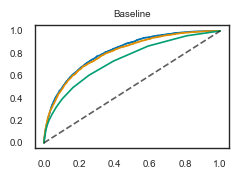

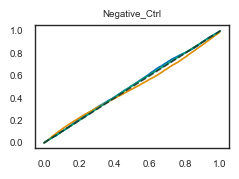

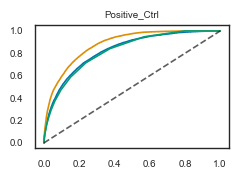

In [43]:
# Szenarien mit den korrekten true-label-Vektoren
scenario_data = [
    ('Baseline',      preds_baseline,      y_test),
    ('Negative_Ctrl', preds_negative,      y_train_real),
    ('Positive_Ctrl', preds_positive,      y_train_real),
]

for scenario_name, preds_dict, y_true in scenario_data:
    plt.figure(figsize=(2.4, 1.8))
    
    for model_name, (_, y_prob) in preds_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.7)    # Zufallslinie
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    plt.title(f'{scenario_name}')
    # plt.legend(loc='lower right')
    plt.tight_layout()
    if cfg.save_data:
        plt.savefig(
            f'{cfg.figures_dir}/ROC_{scenario_name}_{current_timestamp}.tiff',
            dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'}
        )
    plt.show()


### The bigger ones

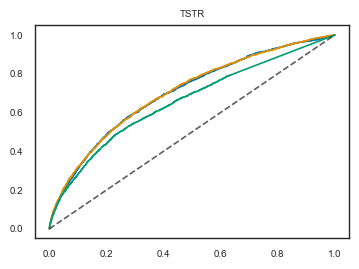

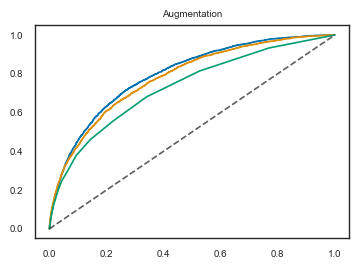

In [42]:
# Szenarien mit den korrekten true-label-Vektoren
scenario_data = [
    ('TSTR',          preds_tstr,          y_test),
    ('Augmentation',  preds_aug,            y_test),
]

for scenario_name, preds_dict, y_true in scenario_data:
    plt.figure(figsize=(3.6, 2.7))
    
    for model_name, (_, y_prob) in preds_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.7)    # Zufallslinie
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    plt.title(f'{scenario_name}')
    # plt.legend(loc='lower right')
    plt.tight_layout()
    if cfg.save_data:
        plt.savefig(
            f'{cfg.figures_dir}/ROC_{scenario_name}_{current_timestamp}.tiff',
            dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'}
        )
    plt.show()


cave: KNN ist sehr datenhungrig. Bei einem Subset von 1000 Punkten kann KNN schlichtweg keine "echten" Nachbarschaften finden, daher bleibt die AUC niedrig, erhöht sich jedoch mit mehr Daten.

## Prediction / Confusion Matrices

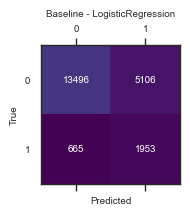

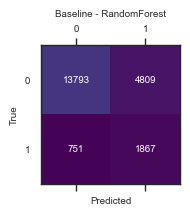

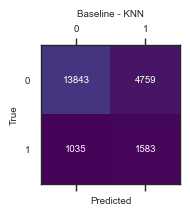

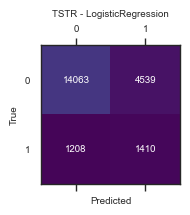

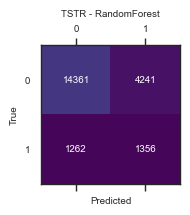

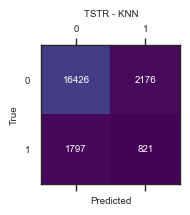

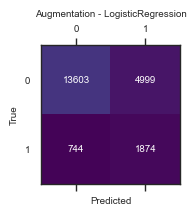

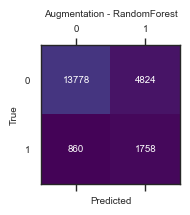

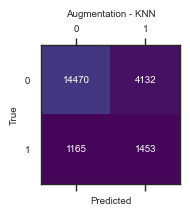

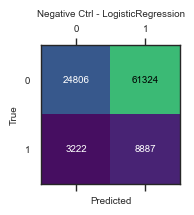

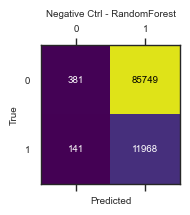

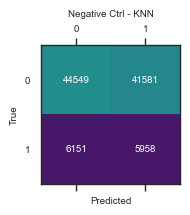

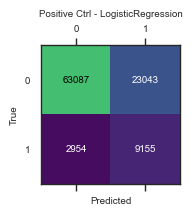

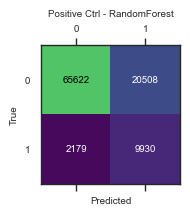

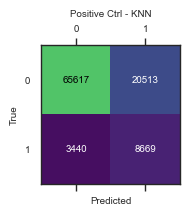

In [54]:
def plot_cm(cm, title, vmax):
    fig, ax = plt.subplots(figsize=(2.4, 1.8))
    im = ax.matshow(cm, cmap='viridis', vmin=0, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

    # Werte in die Felder schreiben
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha='center', va='center',
                 color='white' if v < vmax*0.5 else 'black')

    # ein Farbbalken für die einheitliche Skala
    # cb = fig.colorbar(im)
    # cb.set_ticks(np.linspace(0, vmax, 5, dtype=int))  # z. B. 0, 200, 400, 600, 800

    if cfg:
        plt.savefig(f'{cfg.figures_dir}/CM_{title.strip()}_{current_timestamp}.tiff',
                    dpi=300, format='tiff', bbox_inches='tight',
                    pil_kwargs={'compression': 'tiff_lzw'})
    plt.show()

scenario_data = [
    ('Baseline',       preds_baseline,     y_test),
    ('TSTR',           preds_tstr,         y_test),
    ('Augmentation',   preds_aug,          y_test),
    ('Negative Ctrl',  preds_negative,     y_train_real),
    ('Positive Ctrl',  preds_positive,     y_train_real),
]

# Berechne die maximale Anzahl an Vorhersagen für eine einheitliche Farbskala über alle Plots
conf_matrices = []
for _, preds_dict, y_true in scenario_data:
    for _, (y_pred, _) in preds_dict.items():
        conf_matrices.append(confusion_matrix(y_true, y_pred))
global_max = max(cm.max() for cm in conf_matrices)
global_max = round_up_auto(global_max)

idx = 0
for scenario_name, preds_dict, y_true in scenario_data:
    for model_name, (y_pred, _) in preds_dict.items():
        cm = conf_matrices[idx]
        plot_cm(cm, f"{scenario_name} - {model_name}", vmax=global_max)
        idx += 1

Klassischer Use-Case ist Baseline vs. TSTR (synthetische gegen reale Ergebnisse)
Cohen’s Kappa (κ) misst die Übereinstimmung zweier Klassifikatoren über den Zufalls­level hinaus. Die Kennzahl liegt zwischen –1 und 1:

κ = 1: perfekte Übereinstimmung

κ = 0: nur Zufalls­übereinstimmung

κ < 0: weniger Übereinstimmung als erwartet (systematischer Widerspruch)



Gängige Interpretation nach Landis & Koch:

κ-Wert	Stärke der Übereinstimmung

< 0.00	schlechte (keine)

0.00 – 0.20	gering

0.21 – 0.40	fair

0.41 – 0.60	moderat

0.61 – 0.80	substanziell

0.81 – 1.00	nahezu perfekt

Je höher κ, desto stärker weicht die beobachtete Übereinstimmung von der reinen Zufalls­wahrscheinlichkeit ab. Werte um 0.6 und höher gelten üblicherweise als „gut“.


## Cohen's Kappa

In [31]:
scenario_preds = {
    'Baseline':     preds_baseline,
    'TSTR':         preds_tstr,
    'Augmentation': preds_aug,
    'Negative Ctrl': preds_negative,
    'Positive Ctrl': preds_positive
}

records = []
for (s1, p1), (s2, p2) in combinations(scenario_preds.items(), 2):
    for model_name in ['LogisticRegression', 'RandomForest', 'KNN']:
        # turn each prediction vector into a Series (using default RangeIndex)
        pred1 = pd.Series(p1[model_name][0])
        pred2 = pd.Series(p2[model_name][0])
        
        # align on index → only keep indices present in both
        a1, a2 = pred1.align(pred2, join='inner')
        
        if len(a1) == 0:
            # no overlap (unlikely if both start at 0), skip
            continue
        
        k = cohen_kappa_score(a1, a2)

        # k = cohen_kappa_score(p1[model_name][0], p2[model_name][0])
            
        records.append({
            'model': model_name,
            'scenario_1': s1,
            'scenario_2': s2,
            'kappa': k
        })

df = pd.DataFrame(records)
if cfg.save_data:
    df.to_csv(f'{cfg.results_dir}/Cohens-Kappa_{current_timestamp}.csv', decimal=',', sep=';', encoding='utf-8', index=False)
print(df)


                 model     scenario_1     scenario_2     kappa
0   LogisticRegression       Baseline           TSTR  0.468289
1         RandomForest       Baseline           TSTR  0.566577
2                  KNN       Baseline           TSTR  0.329189
3   LogisticRegression       Baseline   Augmentation  0.780111
4         RandomForest       Baseline   Augmentation  0.825371
5                  KNN       Baseline   Augmentation  0.780058
6   LogisticRegression       Baseline  Negative Ctrl  0.008674
7         RandomForest       Baseline  Negative Ctrl -0.000522
8                  KNN       Baseline  Negative Ctrl  0.008383
9   LogisticRegression       Baseline  Positive Ctrl -0.001549
10        RandomForest       Baseline  Positive Ctrl  0.000017
11                 KNN       Baseline  Positive Ctrl  0.000479
12  LogisticRegression           TSTR   Augmentation  0.664597
13        RandomForest           TSTR   Augmentation  0.706553
14                 KNN           TSTR   Augmentation  0

# Memory Cache leeren

In [32]:
memory.clear(warn=False)